In [1]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2022-10-07 02:49:30--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-10-07 02:49:30 (45.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)

In [5]:
# Walk through each directory
dataset = "../input/pediatric-pnemonia"
walk_through_dir(dataset)

There are 1 directories and 0 images in '../input/pediatric-pnemonia'.
There are 4 directories and 0 images in '../input/pediatric-pnemonia/chest_xray'.
There are 3 directories and 0 images in '../input/pediatric-pnemonia/chest_xray/chest_xray'.
There are 2 directories and 0 images in '../input/pediatric-pnemonia/chest_xray/chest_xray/val'.
There are 0 directories and 8 images in '../input/pediatric-pnemonia/chest_xray/chest_xray/val/PNEUMONIA'.
There are 0 directories and 8 images in '../input/pediatric-pnemonia/chest_xray/chest_xray/val/NORMAL'.
There are 2 directories and 0 images in '../input/pediatric-pnemonia/chest_xray/chest_xray/test'.
There are 0 directories and 390 images in '../input/pediatric-pnemonia/chest_xray/chest_xray/test/PNEUMONIA'.
There are 0 directories and 234 images in '../input/pediatric-pnemonia/chest_xray/chest_xray/test/NORMAL'.
There are 2 directories and 0 images in '../input/pediatric-pnemonia/chest_xray/chest_xray/train'.
There are 0 directories and 3875

In [6]:
image_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.jpeg'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [7]:
image_df

,Filepath,Label
0,../input/pediatric-pnemonia/chest_xray/chest_x...,PNEUMONIA
1,../input/pediatric-pnemonia/chest_xray/chest_x...,PNEUMONIA
2,../input/pediatric-pnemonia/chest_xray/chest_x...,PNEUMONIA
3,../input/pediatric-pnemonia/chest_xray/chest_x...,PNEUMONIA
4,../input/pediatric-pnemonia/chest_xray/chest_x...,PNEUMONIA
...,...,...
14296,../input/pediatric-pnemonia/chest_xray/train/N...,NORMAL
14297,../input/pediatric-pnemonia/chest_xray/train/N...,NORMAL
14298,../input/pediatric-pnemonia/chest_xray/train/N...,NORMAL
14299,../input/pediatric-pnemonia/chest_xray/train/N...,NORMAL


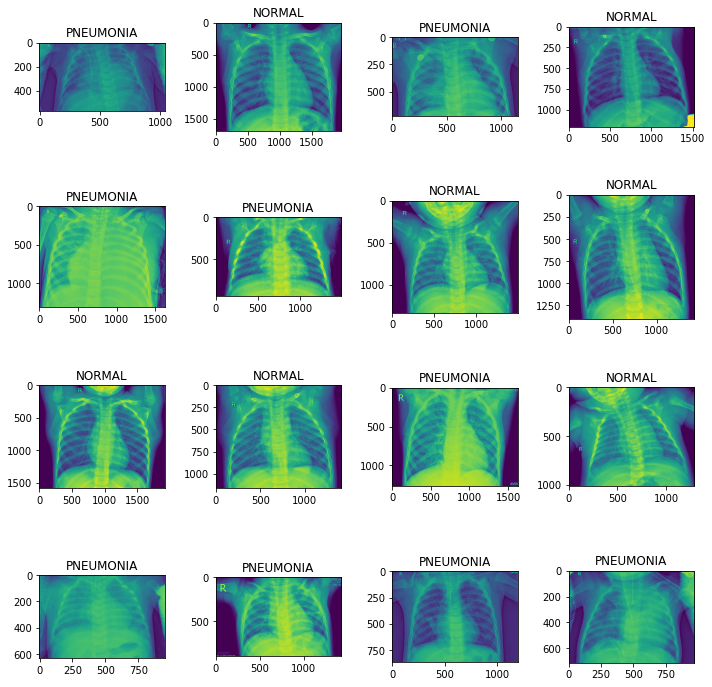

In [8]:
# Display picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 25)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
                        #subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [9]:
def compute_ela_cv(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    SCALE = 15
    orig_img = cv2.imread(path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    
    cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

    # read compressed image
    compressed_img = cv2.imread(temp_filename)

    # get absolute difference between img1 and img2 and multiply by scale
    diff = SCALE * cv2.absdiff(orig_img, compressed_img)
    return diff


def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    ela_filename = 'temp_ela.png'
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1

    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image


def random_sample(path, extension=None):
    if extension:
        items = Path(path).glob(f'*.{extension}')
    else:
        items = Path(path).glob(f'*')
        
    items = list(items)
        
    p = random.choice(items)
    return p.as_posix()

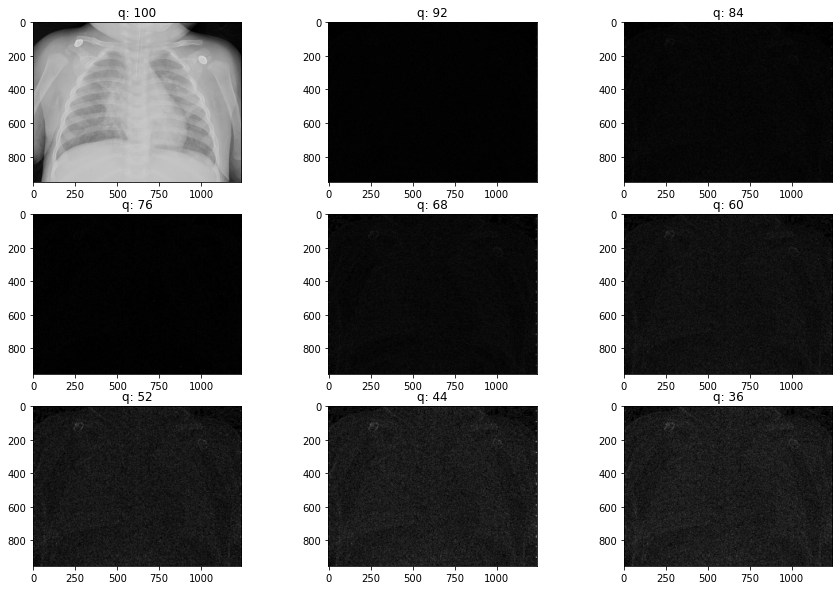

In [11]:
# View random sample from the dataset
p = random_sample('../input/pediatric-pnemonia/chest_xray/train/PNEUMONIA')
orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0
init_val = 100
columns = 3
rows = 3

fig=plt.figure(figsize=(15, 10))
for i in range(1, columns*rows +1):
    quality=init_val - (i-1) * 8
    img = compute_ela_cv(path=p, quality=quality)
    if i == 1:
        img = orig.copy()
    ax = fig.add_subplot(rows, columns, i) 
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)
plt.show()

In [12]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input
)

In [13]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 9152 validated image filenames belonging to 2 classes.
Found 2288 validated image filenames belonging to 2 classes.
Found 2861 validated image filenames belonging to 2 classes.


In [14]:
# Resize Layer
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
])

2022-10-07 02:54:30.868437: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [15]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV3Large(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

17620992/17605208 [==============================] - 0s 0us/step


In [16]:
# Create checkpoint callback
checkpoint_path = "pneumonia classify_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [17]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

In [18]:
inputs = pretrained_model.input
x = resize_and_rescale(inputs)

x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)


outputs = Dense(2, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=30,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs", 
                                    "TB_classification"),
        checkpoint_callback,
    ]
)

2022-10-07 02:55:58.639339: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-10-07 02:55:58.639779: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-10-07 02:55:58.640947: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


Saving TensorBoard log files to: training_logs/TB_classification/20221007-025558


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
2022-10-07 02:55:59.582019: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30
  1/286 [..............................] - ETA: 28:20 - loss: 0.8576 - accuracy: 0.5938

2022-10-07 02:56:05.744880: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-10-07 02:56:05.744942: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  2/286 [..............................] - ETA: 3:31 - loss: 0.9471 - accuracy: 0.4688 

2022-10-07 02:56:06.343934: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-10-07 02:56:06.358883: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-10-07 02:56:06.381444: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: training_logs/TB_classification/20221007-025558/train/plugins/profile/2022_10_07_02_56_06

2022-10-07 02:56:06.386816: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to training_logs/TB_classification/20221007-025558/train/plugins/profile/2022_10_07_02_56_06/7330092cdf7d.trace.json.gz
2022-10-07 02:56:06.419521: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: training_logs/TB_classification/20221007-025558/train/plugins/profile/2022_10_07_02_56_06

2022-10-07 02:56:06.422983: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_pr

286/286 [==============================] - 303s 1s/step - loss: 0.5126 - accuracy: 0.7390 - val_loss: 0.2802 - val_accuracy: 0.9087
Epoch 2/30
286/286 [==============================] - 292s 1s/step - loss: 0.2710 - accuracy: 0.8957 - val_loss: 0.1979 - val_accuracy: 0.9305
Epoch 3/30
286/286 [==============================] - 259s 906ms/step - loss: 0.2133 - accuracy: 0.9149 - val_loss: 0.1681 - val_accuracy: 0.9379
Epoch 4/30
286/286 [==============================] - 266s 931ms/step - loss: 0.1830 - accuracy: 0.9299 - val_loss: 0.1510 - val_accuracy: 0.9436
Epoch 5/30
286/286 [==============================] - 251s 877ms/step - loss: 0.1638 - accuracy: 0.9410 - val_loss: 0.1386 - val_accuracy: 0.9506
Epoch 6/30
286/286 [==============================] - 259s 906ms/step - loss: 0.1526 - accuracy: 0.9438 - val_loss: 0.1328 - val_accuracy: 0.9576
Epoch 7/30
286/286 [==============================] - 258s 901ms/step - loss: 0.1435 - accuracy: 0.9466 - val_loss: 0.1230 - val_accuracy: 0.

In [19]:
 model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 112, 112, 16) 432         rescaling_1[0][0]                
__________________________________________________________________________________________________
Conv/BatchNorm (BatchNormalizat (None, 112, 112, 16) 64          Conv[0][0]                       
______________________________________________________________________________________________

In [20]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.06169
Test Accuracy: 97.80%


In [21]:
results2 = model.evaluate(train_images, verbose=0)

print("    Train Loss: {:.5f}".format(results[0]))
print("Train Accuracy: {:.2f}%".format(results[1] * 100))

    Train Loss: 0.06169
Train Accuracy: 97.80%


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  from ipykernel import kernelapp as app


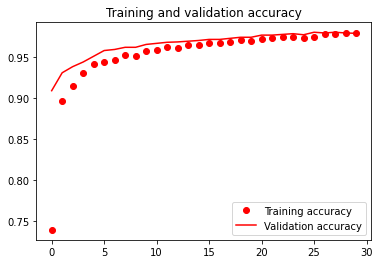

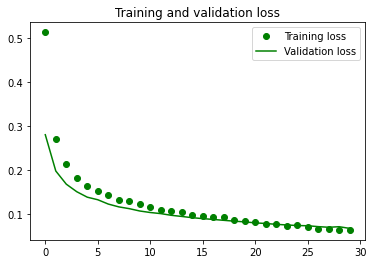

In [22]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy', color ='red')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy', color='red')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss', color='green')
plt.plot(epochs, val_loss, 'b', label='Validation loss', color='green')

plt.title('Training and validation loss')
plt.legend()
plt.show()

In [23]:
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

The first 5 predictions: ['PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA']


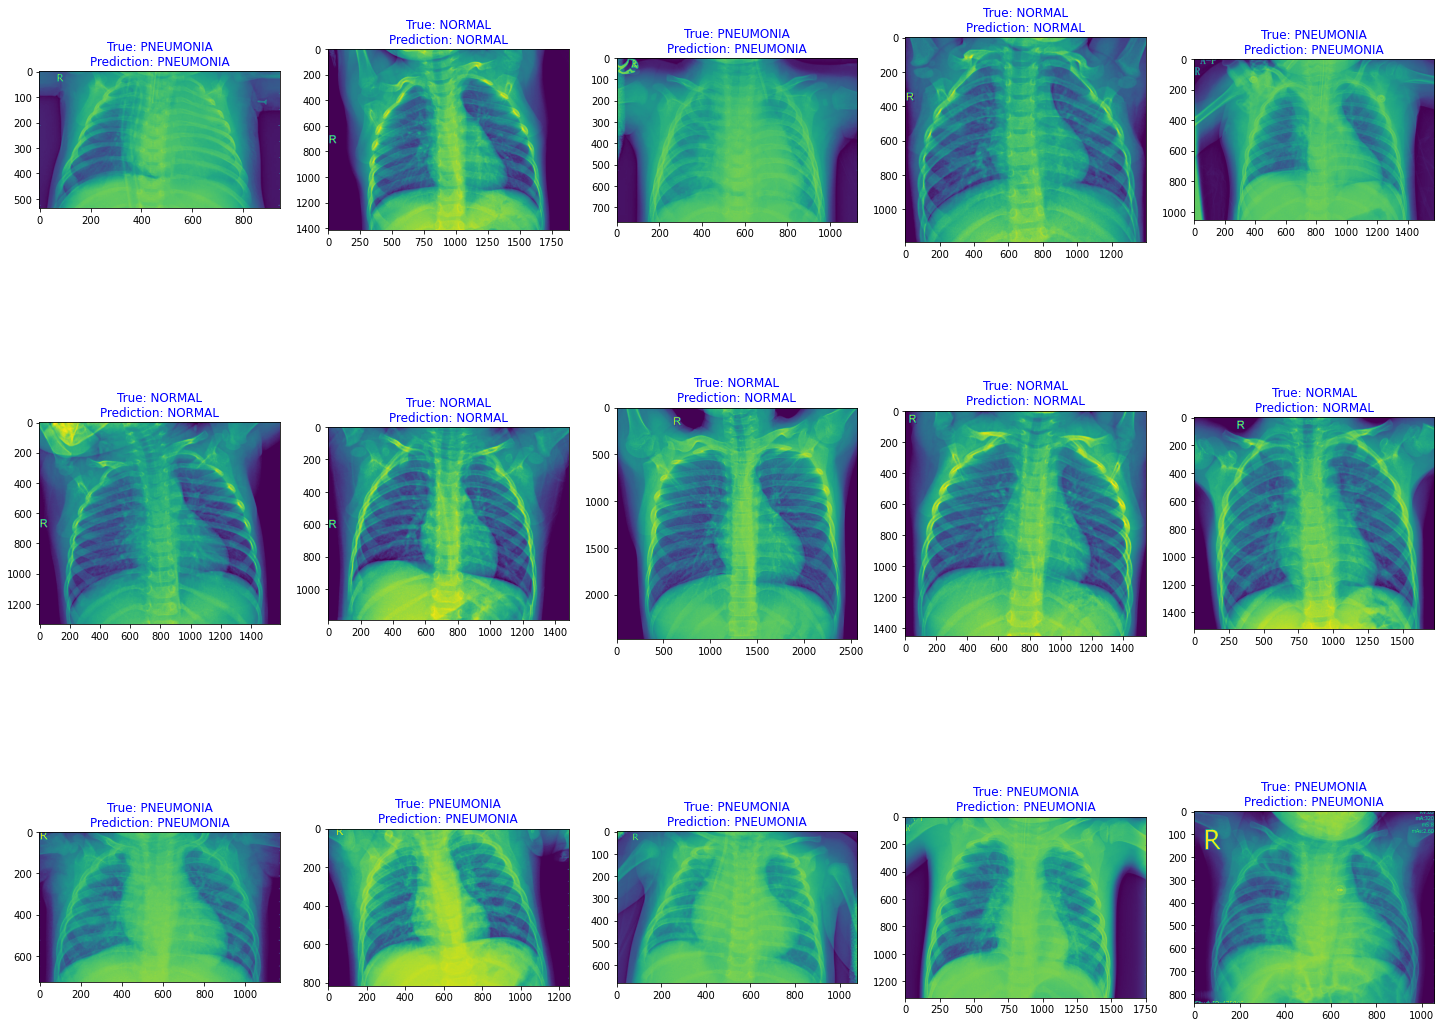

<Figure size 432x288 with 0 Axes>

In [24]:
# Display 50 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 50)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 20))
                        #subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
      color = "blue"
    else:
      color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPrediction: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

In [25]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

      NORMAL       0.97      0.97      0.97      1080
   PNEUMONIA       0.98      0.98      0.98      1781

    accuracy                           0.98      2861
   macro avg       0.98      0.98      0.98      2861
weighted avg       0.98      0.98      0.98      2861



In [26]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
NORMAL,0.969529,0.972222,0.970874,1080.00000
PNEUMONIA,0.983127,0.981471,0.982298,1781.00000
accuracy,0.977980,0.977980,0.977980,0.97798
macro avg,0.976328,0.976847,0.976586,2861.00000
weighted avg,0.977994,0.977980,0.977986,2861.00000


In [27]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(15, 7), text_size=10, norm=False, savefig=False): 
    """Makes a labelled confusion matrix comparing predictions and ground truth labels.

    If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
    """  
  # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0] # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])
  
    # Label the axes
    ax.set(title="Confusion Matrix",
         xlabel="Prediction",
         ylabel="True",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
    plt.xticks(rotation=90, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.jpg")

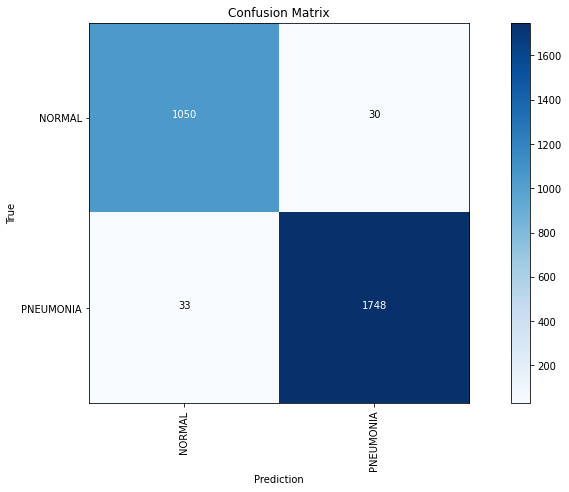

In [28]:
make_confusion_matrix(y_test, pred, list(labels.values()))

In [29]:
specificity1 = confusion_matrix(y_test, pred)[1,1]/(confusion_matrix(y_test, pred)[1,0]+confusion_matrix(y_test, pred)[1,1])
print('Specificity : ', specificity1)

Specificity :  0.9814710836608647


In [30]:
sensitivity1 = confusion_matrix(y_test, pred)[0,0]/(confusion_matrix(y_test, pred)[0,0]+confusion_matrix(y_test, pred)[0,1])
print('Sensitivity : ', sensitivity1 )

Sensitivity :  0.9722222222222222
